In [90]:
import sys
sys.path.append('/home/a202192010/2024/Paper_brain_tumor/models') # put the path to models folder

print(sys.path)

['/home/a202192010/2024/Paper_brain_tumor', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/a202192010/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/a202192010/2024/Paper_brain_tumor/models', '/home/a202192010/2024/Paper_brain_tumor/models']


In [91]:
import tensorflow as tf
import os
import numpy as np

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

### data_load

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


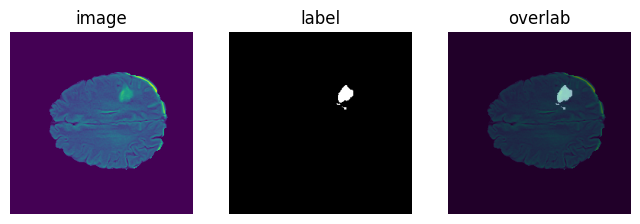

In [110]:
from dataloader import DataProcessor

# 데이터 경로 설정
train_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
val_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
test_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'

# DataProcessor 클래스 인스턴스 생성
data_processor = DataProcessor(train_path, val_path, test_path)

# 데이터 로드 및 처리
data_processor.load_and_process_data()

# 데이터셋의 크기 출력
data_processor.print_shapes()

# 첫 번째 테스트 이미지 시각화
data_processor.visualize_image(num=0)

In [111]:
train_images = data_processor.train_images
train_labels = data_processor.train_labels
val_images = data_processor.val_images
val_labels = data_processor.val_labels
test_images = data_processor.test_images
test_labels = data_processor.test_labels

### 데이터 샘플링

In [112]:
from ImageProcessor import ImageProcessor

def process_datasets(train_images, train_labels, val_images, val_labels, test_images, test_labels, threshold, fraction):
    train_processor = ImageProcessor(train_images, train_labels)
    train_images, train_labels = train_processor.select_images(threshold)
    train_images, train_labels = train_processor.sample_data(fraction)
    
    val_processor = ImageProcessor(val_images, val_labels)
    val_images, val_labels = val_processor.select_images(threshold)
    val_images, val_labels = val_processor.sample_data(fraction)
    
    test_processor = ImageProcessor(test_images, test_labels)
    test_images, test_labels = test_processor.select_images(threshold)
    test_images, test_labels = test_processor.sample_data(fraction)
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)



In [113]:
import numpy as np

threshold = 3000
fraction = 0.1

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = process_datasets(
    train_images, train_labels, val_images, val_labels, test_images, test_labels, threshold, fraction
)

In [114]:
train_images.shape

(391, 240, 240, 4)

In [115]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (391, 240, 240, 4)
Train labels shape: (391, 240, 240)
Validation images shape: (131, 240, 240, 4)
Validation labels shape: (131, 240, 240)
Test images shape: (131, 240, 240, 4)
Test labels shape: (131, 240, 240)


In [134]:
num = 130

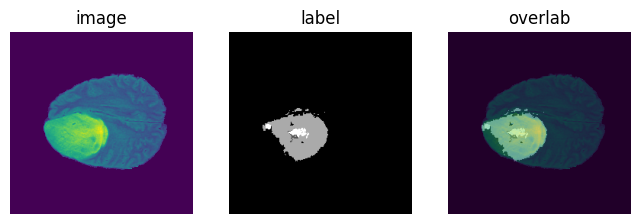

In [135]:
plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(test_images[num, :, :, 3])
plt.title("image")
plt.axis("off")
plt.subplot(132)
plt.imshow(test_labels[num, :, :], cmap='gray')
plt.title("label")
plt.axis("off")
plt.subplot(133)
plt.imshow(test_labels[num, :, :], cmap='gray')
plt.title("overlab")
plt.axis("off")
plt.imshow(test_images[num, :, :, 3], alpha=0.5)
plt.axis("off")
plt.show()

(-0.5, 239.5, 239.5, -0.5)

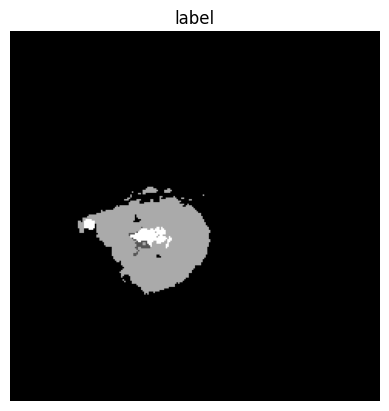

In [136]:
plt.imshow(test_labels[num, :, :], cmap='gray')
plt.title("label")
plt.axis("off")

In [139]:
class_1_count = np.sum(train_labels[num, :, :] == 1)
class_2_count = np.sum(train_labels[num, :, :] == 2)
class_3_count = np.sum(train_labels[num, :, :] == 3)

In [140]:
print(class_1_count)
print(class_2_count)
print(class_3_count)

573
912
341


### categorical-label

In [141]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4) # 레이블 원핫 인코딩
val_labels = to_categorical(val_labels, num_classes=4)

### model

In [142]:
from res_unet_2plus import f_model ## model

input_shape = (240, 240, 4) # change channel by the shape of dataset
num_classes = 4
model = f_model(input_shape, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 240, 240, 16)         592       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 240, 240, 16)         64        ['conv2d_41[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_23 (Activation)  (None, 240, 240, 16)         0         ['batch_normalization_30

 conv2d_49 (Conv2D)          (None, 60, 60, 64)           2112      ['multiply_10[0][0]']         
                                                                                                  
 add_14 (Add)                (None, 60, 60, 64)           0         ['conv2d_48[0][0]',           
                                                                     'conv2d_49[0][0]']           
                                                                                                  
 global_average_pooling2d_8  (None, 64)                   0         ['add_14[0][0]']              
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 reshape_8 (Reshape)         (None, 1, 1, 64)             0         ['global_average_pooling2d_8[0
                                                                    ][0]']                        
          

                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 256)          0         ['conv2d_58[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_59 (Conv2D)          (None, 30, 30, 256)          590080    ['activation_31[0][0]']       
                                                                                                  
 add_17 (Add)                (None, 30, 30, 256)          0         ['max_pooling2d_3[0][0]',     
                                                                     'conv2d_59[0][0]']           
                                                                                                  
 batch_normalization_43 (Ba  (None, 30, 30, 256)          1024      ['add_17[0][0]']              
 tchNormal

 tchNormalization)                                                                                
                                                                                                  
 activation_37 (Activation)  (None, 60, 60, 128)          0         ['batch_normalization_48[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 60, 60, 128)          147584    ['activation_37[0][0]']       
                                                                                                  
 multiply_14 (Multiply)      (None, 60, 60, 128)          0         ['conv2d_66[0][0]',           
                                                                     'add_18[0][0]']              
                                                                                                  
 up_sampli

 up_sampling2d_5 (UpSamplin  (None, 240, 240, 64)         0         ['multiply_16[0][0]']         
 g2D)                                                                                             
                                                                                                  
 concatenate_5 (Concatenate  (None, 240, 240, 80)         0         ['up_sampling2d_5[0][0]',     
 )                                                                   'add_12[0][0]']              
                                                                                                  
 global_average_pooling2d_1  (None, 80)                   0         ['concatenate_5[0][0]']       
 1 (GlobalAveragePooling2D)                                                                       
                                                                                                  
 reshape_11 (Reshape)        (None, 1, 1, 80)             0         ['global_average_pooling2d_11[
          

### fit

In [143]:
from tensorflow.keras.losses import CategoricalCrossentropy

histories = []
model_paths = {}

loss_fn = CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
history= model.fit(train_images, train_labels, epochs=100, batch_size=16, validation_data=(val_images, val_labels))
histories.append(history.history)

Epoch 1/100
25/25 [==============================] - 67s 539ms/step - loss: 1.1284 - accuracy: 0.8974 - val_loss: 0.7358 - val_accuracy: 0.9794
Epoch 2/100
25/25 [==============================] - 4s 166ms/step - loss: 0.4234 - accuracy: 0.9773 - val_loss: 14.9071 - val_accuracy: 0.9644
Epoch 3/100
25/25 [==============================] - 4s 166ms/step - loss: 0.1820 - accuracy: 0.9811 - val_loss: 0.9035 - val_accuracy: 0.9756
Epoch 4/100
25/25 [==============================] - 4s 165ms/step - loss: 0.1303 - accuracy: 0.9814 - val_loss: 0.1145 - val_accuracy: 0.9798
Epoch 5/100
25/25 [==============================] - 4s 166ms/step - loss: 0.1191 - accuracy: 0.9815 - val_loss: 0.1078 - val_accuracy: 0.9798
Epoch 6/100
25/25 [==============================] - 4s 165ms/step - loss: 0.0907 - accuracy: 0.9833 - val_loss: 0.1065 - val_accuracy: 0.9794
Epoch 7/100
25/25 [==============================] - 4s 168ms/step - loss: 0.0937 - accuracy: 0.9835 - val_loss: 0.1151 - val_accuracy: 0.97

Epoch 58/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.0373 - val_accuracy: 0.9869
Epoch 59/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 0.0268 - val_accuracy: 0.9907
Epoch 60/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0200 - accuracy: 0.9929 - val_loss: 0.0279 - val_accuracy: 0.9905
Epoch 61/100
25/25 [==============================] - 4s 168ms/step - loss: 0.0202 - accuracy: 0.9929 - val_loss: 0.0307 - val_accuracy: 0.9890
Epoch 62/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0207 - accuracy: 0.9926 - val_loss: 0.0436 - val_accuracy: 0.9870
Epoch 63/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.0382 - val_accuracy: 0.9872
Epoch 64/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0201 - accuracy: 0.9927 - val_loss: 0.0238 - val_accuracy:

#### test data evaluate

In [144]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

5/5 - 0s - loss: 0.0196 - accuracy: 0.9931 - 437ms/epoch - 87ms/step


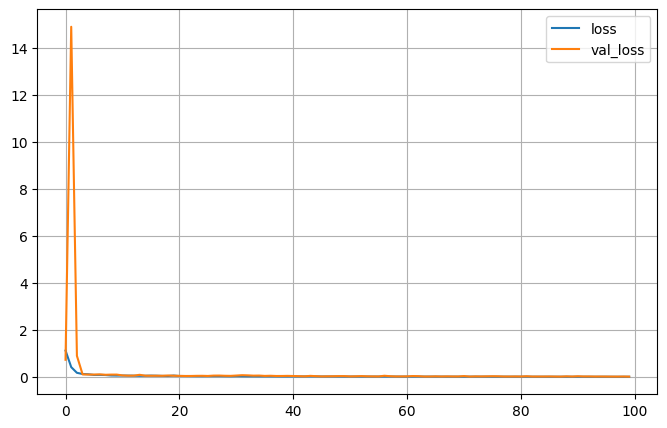

(<matplotlib.legend.Legend at 0x7f3c7b263850>, None, None)

In [145]:
import matplotlib.pyplot as plt

plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

In [146]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

5/5 [==============================] - 3s 75ms/step


### results

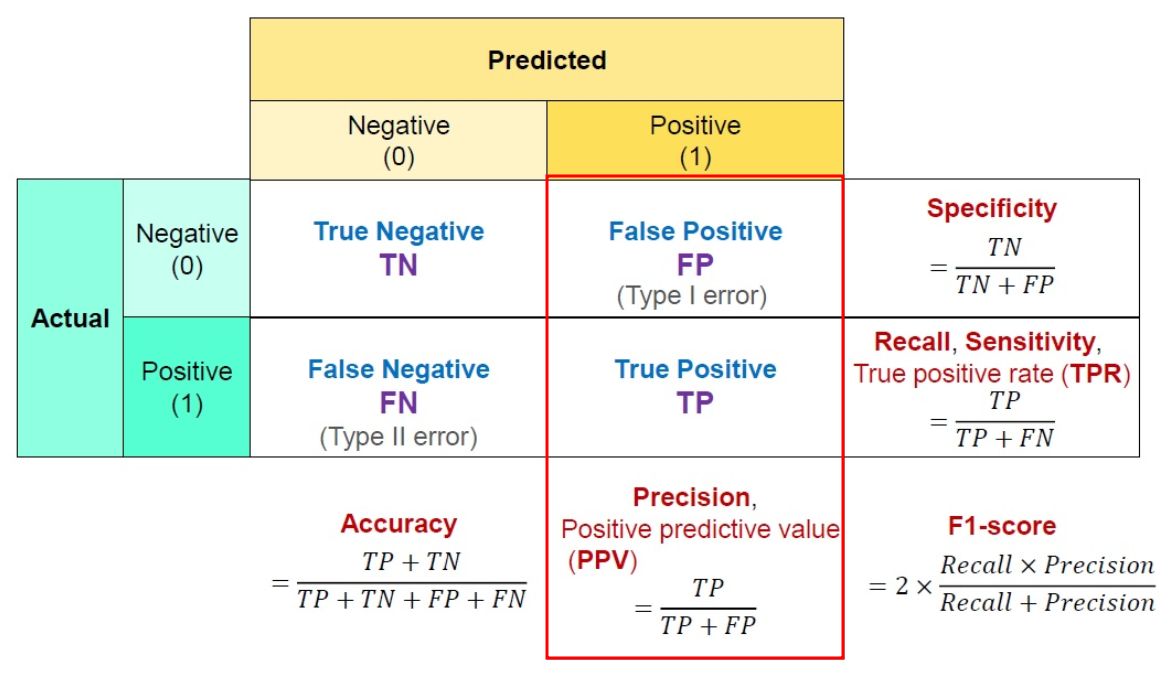

In [147]:
import pandas as pd
from metrix import sensitivity,specificity,F1_score,precision

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=[0,1,2,3])
df.loc['Col Ave'] = df.mean()

df

,Sensitivity,Specificity,F1 Score,Precision
0,0.999200,0.7985,0.997400,0.995600
1,0.575000,0.9997,0.691200,0.866200
2,0.716800,0.9987,0.792000,0.884900
3,0.821500,0.9991,0.800300,0.780200
Col Ave,0.778125,0.9490,0.820225,0.881725


1 )
1/1 [==============================] - 0s 62ms/step
mismatched labels: 255


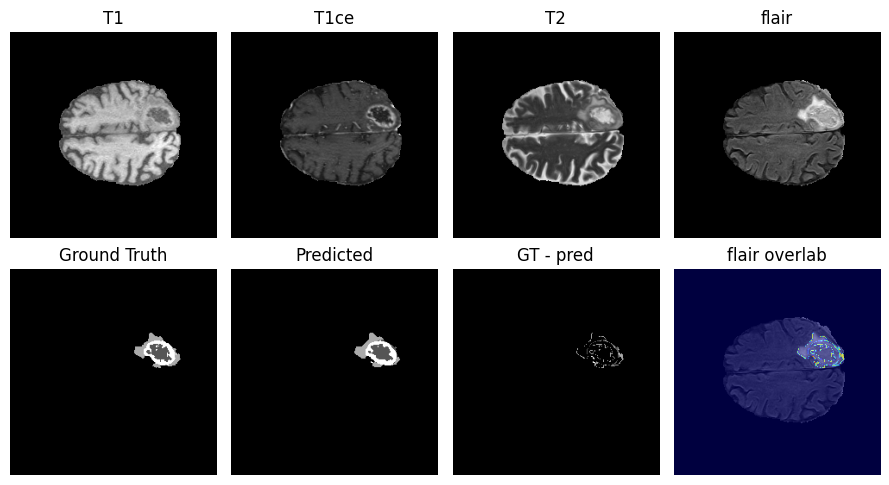

2 )
1/1 [==============================] - 0s 64ms/step
mismatched labels: 452


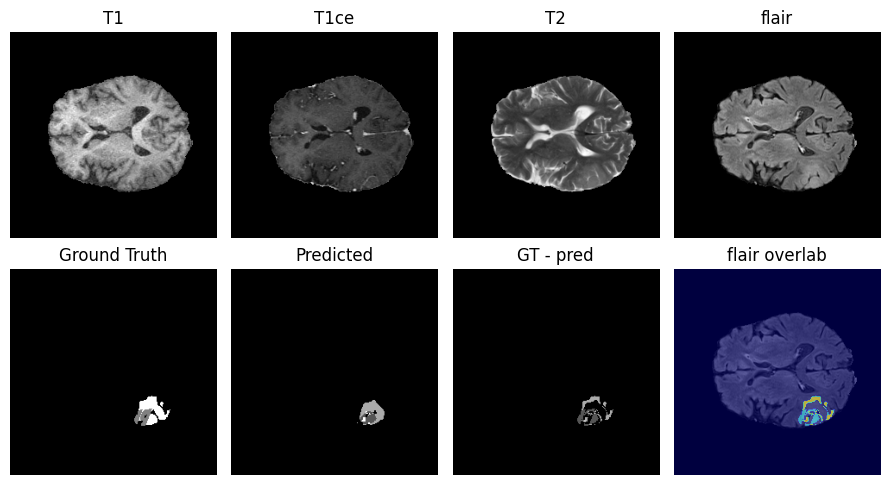

3 )
1/1 [==============================] - 0s 61ms/step
mismatched labels: 359


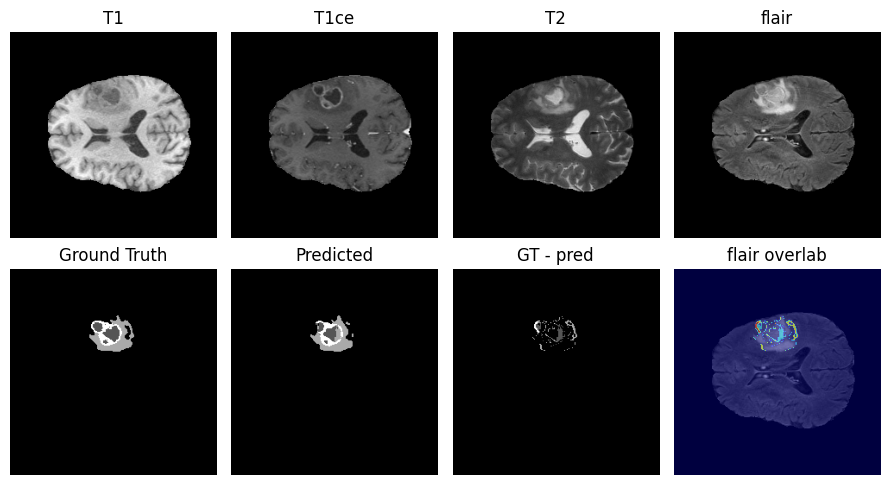

4 )
1/1 [==============================] - 0s 61ms/step
mismatched labels: 494


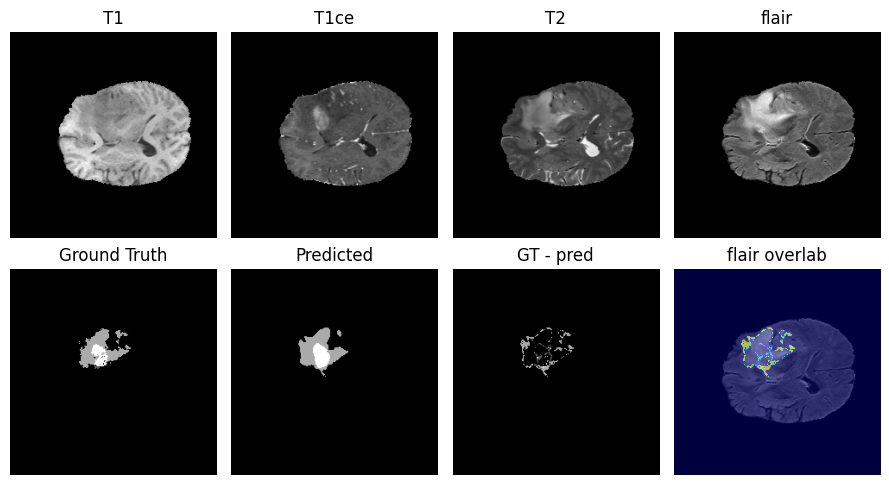

5 )
1/1 [==============================] - 0s 61ms/step
mismatched labels: 375


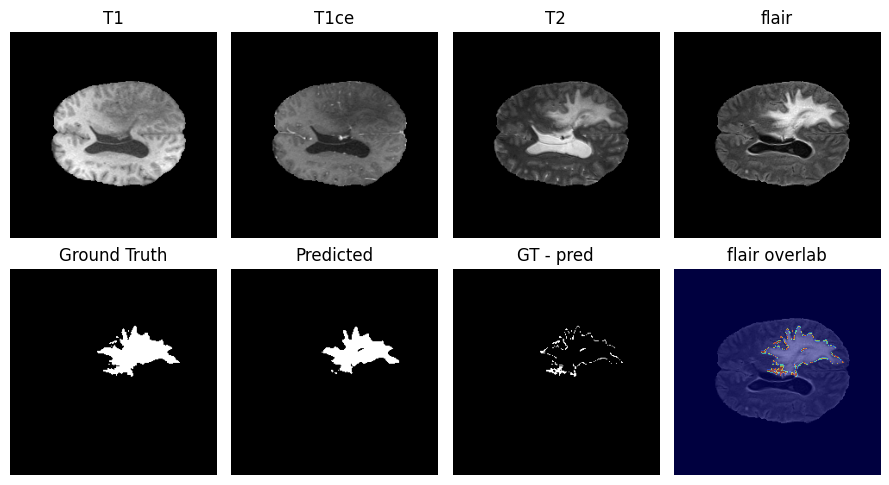

In [148]:
from testvisual import visual_num

for i in range(5):
    print(i + 1, ")")
    visual_num(i, test_images, test_labels, model)

In [ ]:
model.save('brain_tumor_base.h5')